In [124]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import math
from scipy.stats import laplace
from scipy import stats
from random import shuffle

In [125]:
SIZE = 1000

In [126]:
def get_F_vals(nums):
    nums = np.sort(nums)
    
    F = dict()
    n = len(nums)
    
    for x in nums:
        F[x] = len(nums[nums<x]) / n
        
    return F

In [127]:
def get_emp_F(nums):
    F_vals = get_F_vals(nums)
    least = min(F_vals, key=F_vals.get)
    great = max(F_vals, key=F_vals.get)
    def emp_F(x):
        nonlocal F_vals, least, great
        if x < least:
            return 0
        elif x > great:
            return 1
        else:
            return F_vals[x]
    return emp_F

In [128]:
def series(nums):

    nums_ord = list(sorted(nums))
    size = len(nums)

    if size % 2 != 0:
        med_idx = int((size + 1) / 2)
        med = nums_ord[med_idx]
        nums.pop(med_idx)
    else:
        med_idx_f = math.floor(size / 2)
        med_idx_c = math.ceil(size / 2)
        med = (nums_ord[med_idx_f] + nums_ord[med_idx_c]) / 2

    sign = [elem > med for elem in nums]  # True is +; False is -

    nps, nms = 0, 0
    previous_s = sign[0]

    for s in sign[1:]:

        if s != previous_s and previous_s:
            nms += 1
        elif s != previous_s and not previous_s:
            nps += 1

        previous_s = s

    r = nms + nps
    nm = sum(1 for s in sign if not s)
    np = sum(1 for s in sign if s)

    mu = 2*np*nm / size + 1
    sigma_sq = 2*np*nm*(2*np*nm - size) / ((size**2)*(size - 1))
    sigma = sigma_sq**0.5

    return (r - mu) / sigma

In [129]:
def kolmogorov(nums):
    nums = list(sorted(nums))
    emp_F = get_emp_F(nums)
    size = len(nums)
    return size**0.5 * max(
        max(
            [abs(emp_F(nums[i]) - stats.norm.cdf(nums[i])), abs(emp_F(nums[i + 1]) - stats.norm.cdf(nums[i]))]
        ) for i in range(size - 1)
    )

In [130]:
def lemers_method(x0, a=6364136223846793005, module=2**64, size=SIZE):
    nums = list()

    for _ in range(size):
        x1 = a * x0 % module
        val = x1 / module

        if val in nums:
            print('Generated value in random numbers')
            return nums

        nums.append(val)
        x0 = x1
    return nums

$\xi = a + (b - a) * \gamma$

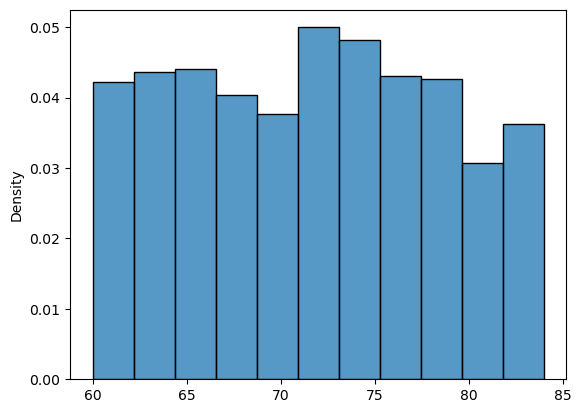

In [131]:
a = 60
b = 84

uniform_dist = a + (b - a) * np.array(lemers_method(200))
sns.histplot(x=uniform_dist, stat='density');

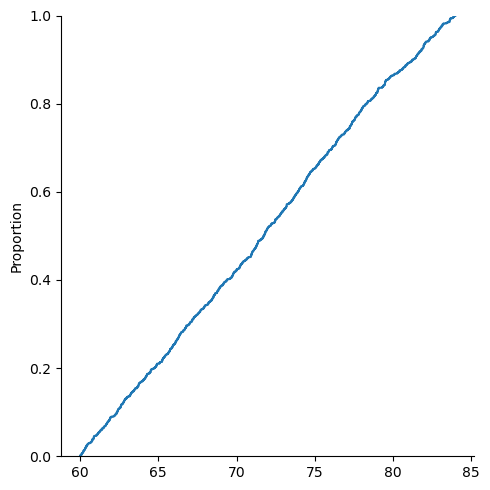

In [274]:
sns.displot(data=uniform_dist, kind="ecdf")

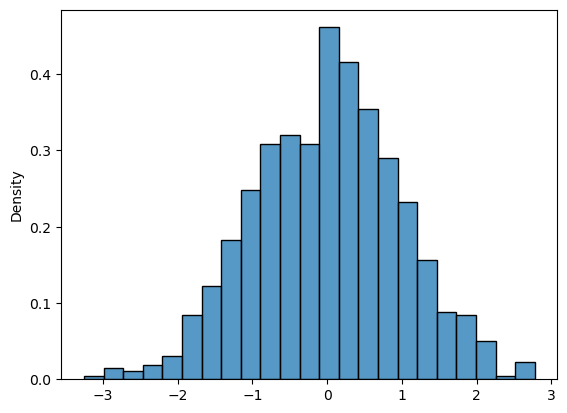

In [267]:
n = 12
normal_std_dist = list()
normal_std_dist = np.zeros(SIZE)

numb = 0

for i in range(n):
    np.random.seed(i)
    normal_std_dist += np.random.uniform(size=SIZE)
    

normal_std_dist = normal_std_dist - n/2
sns.histplot(x=normal_std_dist, stat='density');

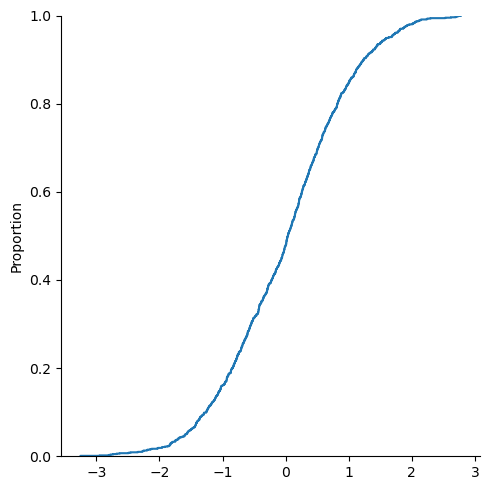

In [275]:
sns.displot(data=normal_std_dist, kind="ecdf")

In [268]:
normal_std_dist.mean()

0.0004861433212263702

In [269]:
normal_std_dist.std()

0.97916149179841

In [270]:
# series method |z| < 2.8 for a=0.01
series(list(normal_std_dist))

-1.32870062546053

In [271]:
# K^-1(0.005) = 0.41709; k^-1(0.995) = 1.73083
kolmogorov(normal_std_dist)

0.8472889253182382

In [272]:
_, p_value = stats.kstest(normal_std_dist, "norm", alternative='two-sided')

print("p-value:", p_value)

p-value: 0.4615171537761087


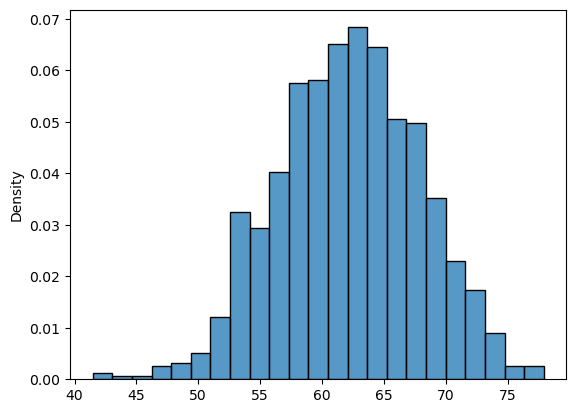

In [138]:
m = 62
s = 6

normal_dist = m + normal_std_dist * s
sns.histplot(x=normal_dist, stat='density');

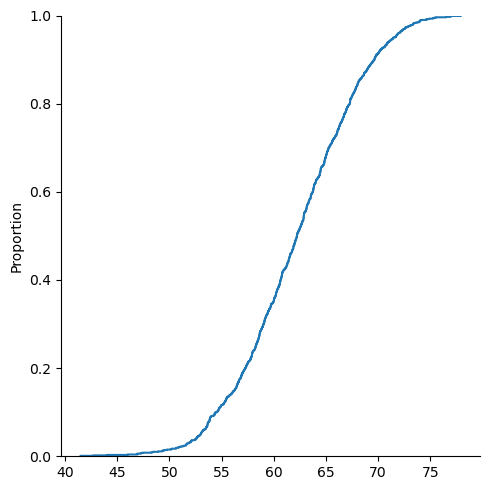

In [276]:
sns.displot(data=normal_dist, kind="ecdf")

In [140]:
normal_dist.mean()

62.15479825126509

In [141]:
normal_dist.std()

5.723082279558216

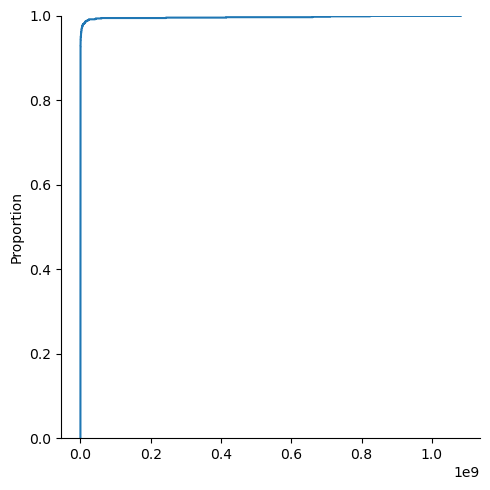

In [313]:
lognormal_dist = np.exp(6*normal_std_dist)*m
# sns.histplot(x=lognormal_dist, stat='density');
sns.displot(data=lognormal_dist, kind="ecdf")

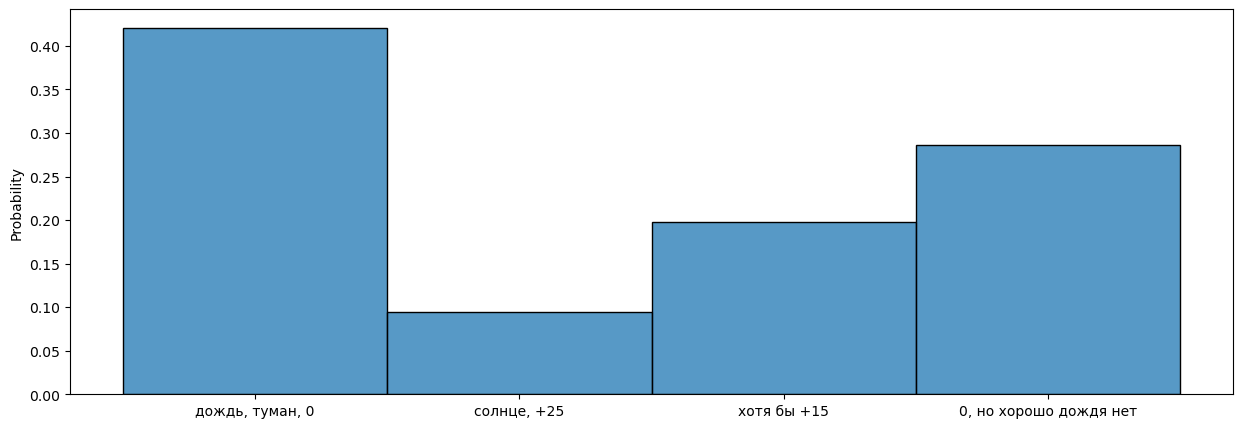

In [143]:
values = ['солнце, +25',
          'хотя бы +15',
          '0, но хорошо дождя нет',
          'дождь, туман, 0']
p_values = [0, 0.1, 0.2, 0.3, 0.4]

assert sum(p_values) == 1
assert p_values[0] == 0
n = len(p_values)
discret_dist = list()

for p_cont in lemers_method(2023):
    for np_disc in range(1, n):
        if sum(p_values[:np_disc]) < p_cont < sum(p_values[:np_disc + 1]):
            discret_dist.append(values[np_disc-1])
discret_dist = np.array(discret_dist)
plt.figure(figsize=(15, 5))
sns.histplot(x=discret_dist, stat='probability');

In [144]:
discret_dist[:10]

array(['дождь, туман, 0', 'дождь, туман, 0', 'солнце, +25',
       'дождь, туман, 0', 'хотя бы +15', 'дождь, туман, 0',
       '0, но хорошо дождя нет', 'хотя бы +15', 'солнце, +25',
       'солнце, +25'], dtype='<U22')

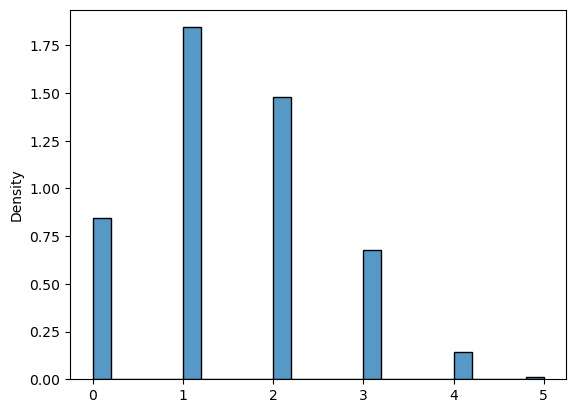

In [145]:
binomial_dist = list()
p = 0.3
n = 5

for i in range(1000):
    gamma = np.array(lemers_method(i + 20, size=n))
    binomial_dist.append((gamma<p).sum())
binomial_dist = np.array(binomial_dist)
sns.histplot(x=binomial_dist, stat='density')
plt.xticks(list(range(n+1)));

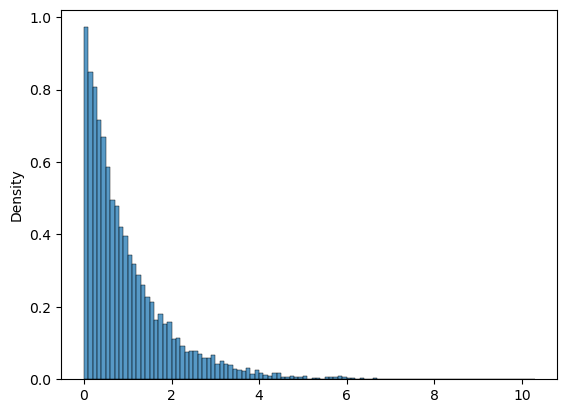

In [307]:
exponential_dist = -np.log(np.array(lemers_method(2003, size=10000)))
sns.histplot(x=exponential_dist, stat='density');

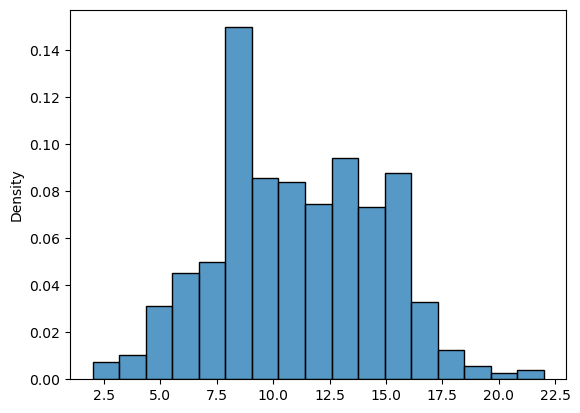

In [308]:
lmd = 12

poisson_dist = list()
exponential_dist_ = exponential_dist.copy()

s = 0
numb = 0

while len(exponential_dist_) > numb:
    
    s += exponential_dist_[numb]
    
    if s > lmd:
        poisson_dist.append(numb)
        exponential_dist_ = exponential_dist_[numb:]
        numb = 0
        s = 0
    else:
        numb += 1
    
sns.histplot(x=poisson_dist, stat='density');

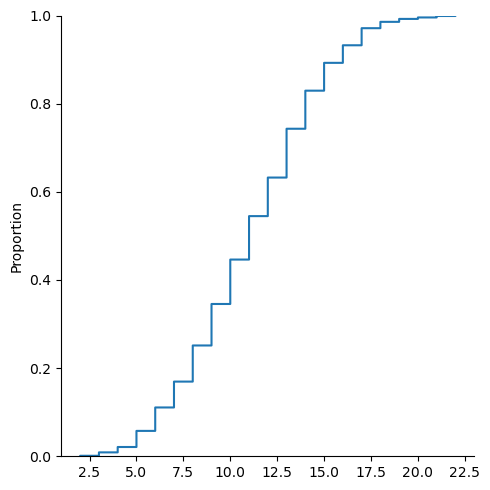

In [309]:
sns.displot(data=poisson_dist, kind="ecdf")

In [310]:
np.array(poisson_dist).mean()

11.069767441860465

In [311]:
len(poisson_dist)

903

In [312]:
np.array(poisson_dist).std()**2

12.552164619227899